## generate RoBERTa-KD report

In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import time
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import json

# # Load tokenizer and model # LATEST CodeBERT KD Model
# tokenizer = RobertaTokenizer.from_pretrained('ManojAlexender/second_Base_version_of_codebert_with_commit_and_diff')
# model = RobertaForSequenceClassification.from_pretrained('ManojAlexender/second_Base_version_of_codebert_with_commit_and_diff')

# Load tokenizer and model # OLD KD MODEL
tokenizer = RobertaTokenizer.from_pretrained('ManojAlexender/final_roberta_with_new_400k_plus_37k_Best')
model = RobertaForSequenceClassification.from_pretrained('ManojAlexender/final_roberta_with_new_400k_plus_37k_Best')


# Load the data from the .jsonl file
data = []
y_true = []
commit_messages = []  # To store commit messages
code_diffs = []  # To store code diffs
commit_urls = []

with open('../gt_final.jsonl', 'r') as f:
    for line in f:
        record = json.loads(line)
        # Concatenate 'commit_message' and 'code_diff' fields for the model
        commit_message = '"'+ record['commit_message'].replace('\n', ' ') + '"'
        code_diff = record['code_diff']
        commit_url = record['commit_url']
        #data.append(commit_message + ' ' + code_diff) # commit+diff
        data.append(commit_message) #commitonly
        # Append the target field to y_true
        y_true.append(record['target'])
        # Store the commit_message and code_diff for later writing
        commit_messages.append(commit_message)
        code_diffs.append(code_diff)
        commit_urls.append(commit_url)
        

# Convert y_true to a numpy array for later use
y_true = np.array(y_true)

# Function to process data instance by instance and calculate predictions
def predict_instance_by_instance(model, tokenizer, data):
    model.to('cuda')
    model.eval()
    all_predictions = []

    for instance in data:
        inputs = tokenizer(instance, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
        all_predictions.append(prediction)

    return all_predictions

# Run prediction once and generate the classification report
predictions = predict_instance_by_instance(model, tokenizer, data)

# Convert predictions to numpy array and adjust labels if necessary
predictions = np.array(predictions)
predictions[predictions == 2] = 0  # Adjust according to your label scheme if needed

In [5]:
import csv

# Verify that the predictions array has the same length as the original data
assert len(predictions) == len(data), "Length of predictions does not match the length of the original data."

# Write commit_message, code_diff, target, and predicted values to a CSV file
with open('RoBERTa_KD_goldm_results_latest.csv', 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    # Write header
    csvwriter.writerow(['commit_url', 'original_target', 'predicted'])
    
    # Write data rows
    for i in range(len(data)):
        csvwriter.writerow([commit_urls[i], y_true[i], predictions[i]])

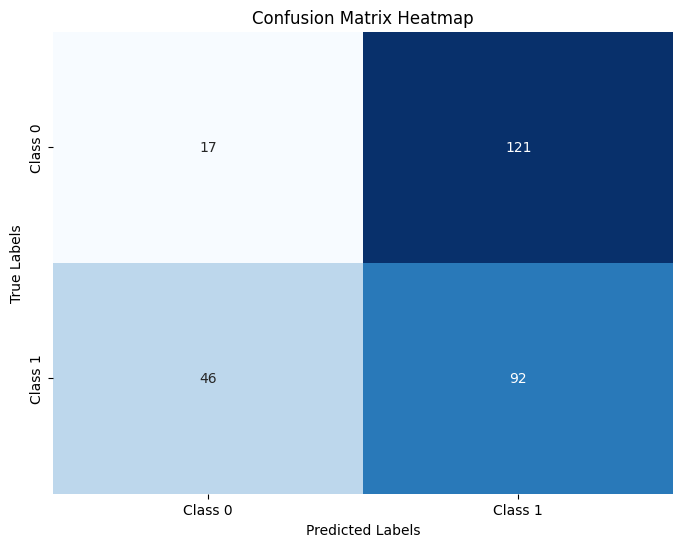

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming 'y_true' and 'predictions' are your actual labels and predicted labels
report = classification_report(y_true, predictions)
conf_matrix = confusion_matrix(y_true, predictions)

# Write the classification report to the same file
with open('RoBERTa_KD_goldm_classification_report_latest.txt', 'w') as file:
    # Write classification report
    file.write("Classification Report:\n")
    file.write(report)
    
    # Write confusion matrix as text
    file.write("\nConfusion Matrix:\n")
    file.write(np.array2string(conf_matrix))

# Plotting the heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the heatmap as an image
plt.savefig('confusion_matrix_heatmap.png')

# Show the plot (optional)
plt.show()